### Coutures panoramiques
À titre d'exemple simple, considérons l'assemblage panoramique où nous avons deux images prises côte à côte avec un certain chevauchement, et nous souhaitons combiner ces deux images pour obtenir un point panoramique. Nous pouvons le faire en trois étapes :
- 1.) Rechercher des fonctionnalités dans les deux images
- 2.) Pour chaque fonctionnalité, trouvez la paire correspondante dans l'autre image
- 3.) Superposez les images de manière à ce que les paires soient alignées le mieux possible

![Panorama Stitching](https://github.com/joelbarmettlerUZH/PyVisualOdometry/raw/master/img/chapter_6/panorama_stitching.png)
*Figure 7: Panorama Stitching. [source](http://rpg.ifi.uzh.ch/docs/teaching/2019/05_feature_detection_1.pdf)*

Le plus difficile est de détecter les mêmes points indépendamment dans les deux images. Nous avons besoin de détecteurs de caractéristiques reproductibles, ce qui signifie que nous devons re-détecter les mêmes caractéristiques d'une image dans une autre. 

Deuxièmement, nous devons trouver distinctement les caractéristiques correspondantes dans les deux images. Pour ce faire, nous utilisons des descripteurs. Les descripteurs sont une description d'un pixel et des caractéristiques qui l'entourent qui identifient le pixel de manière unique et sans ambiguïté. Le descripteur doit être robuste aux changements géométriques et d'éclairage afin que nous puissions trouver le même descripteur dans une image différente. De tels changements géométriques peuvent être : des changements de translation, de rotation, de mise à l'échelle et de perspective.

Un changement d'éclairage est une transformation simple et affine d'une valeur de pixels par un facteur constant *B*. Il peut facilement être surmonté en divisant une image par sa valeur d'intensité moyenne.

L'invariation de rotation est plus difficile à réaliser. Nous pourrions - par exemple - toujours faire pivoter nos entités détectées de telle sorte que les lignes les plus dominantes soient horizontales, mais nous verrons des méthodes plus efficaces plus loin dans cet article.

Lorsque nous détectons des fonctionnalités, nous utilisons généralement deux méthodes différentes : la **détection de coin** et la **détection de blob**.
Un coin est une région de contraste qui change de manière significative dans deux directions perpendiculaires. Il a une très grande précision de localisation mais est souvent difficile à distinguer. En revanche, un Blob est une région d’image qui diffère considérablement de ses voisines – comme un motif petit mais dominant. Les blobs sont moins précis en localisation que les coins, mais sont plus distincts et donc plus faciles à redétecter.

In [1]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from stitch import *

In [2]:
rgb_l = cv2.cvtColor(cv2.imread("images/left.jpg"), cv2.COLOR_BGR2RGB)
gray_l = cv2.cvtColor(rgb_l, cv2.COLOR_RGB2GRAY)
rgb_r = cv2.cvtColor(cv2.imread("images/right.jpg"), cv2.COLOR_BGR2RGB)
gray_r = cv2.cvtColor(rgb_r, cv2.COLOR_RGB2GRAY)



In [3]:
md = cv2.SIFT_create()
# Trouvez des points d'intérêt et des fonctionnalités informatiques.
k0,des1 = md.detectAndCompute(gray_l, None)
k1,des2 = md.detectAndCompute(gray_r, None)

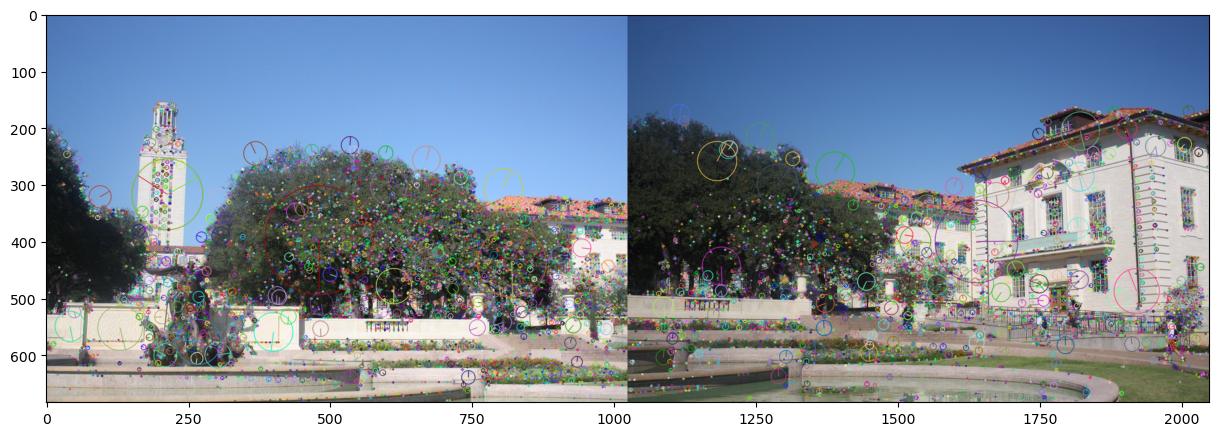

In [4]:
img0_kp= cv2.drawKeypoints(rgb_l.copy(), k0, rgb_l.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img1_kp=cv2.drawKeypoints(rgb_r.copy(), k1, rgb_r.copy(), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

plt_img = np.concatenate((img0_kp, img1_kp), axis=1)
plt.figure(figsize=(15,15))
plt.imshow(plt_img)

In [5]:

# Paramètres FLANN
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50) # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)
matches = flann.knnMatch(des1,des2,k=2)
matchesMask = [[0,0] for i in range(len(matches))]
good = []
for i,(m,n) in enumerate(matches):
 if m.distance < 0.8*n.distance:
    good.append(m)
    matchesMask[i]=[1,0]


In [6]:
src_points = np.float32([k0[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
dst_points = np.float32([k1[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)



In [7]:
draw_params = dict(matchColor = (0,255,0),
 singlePointColor = (255,0,0),
 matchesMask = matchesMask,
 flags = cv2.DrawMatchesFlags_DEFAULT)
img = cv2.drawMatchesKnn(rgb_l.copy(),k0,rgb_r.copy(),k1,matches,None,**draw_params)

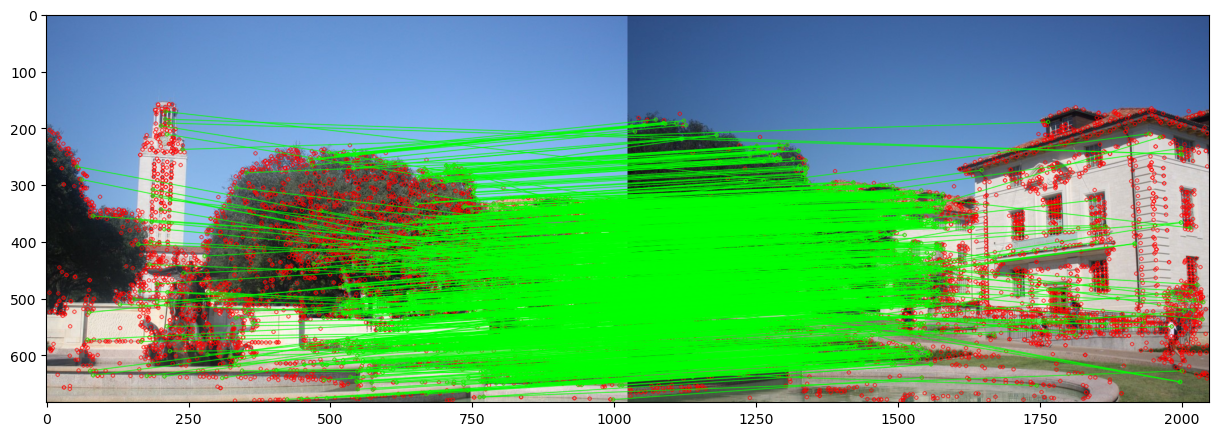

In [8]:
plt.figure(figsize=(15,15))
plt.imshow(img)

In [9]:
H, mask = cv2.findHomography(src_points, dst_points, cv2.RANSAC, 5.0)


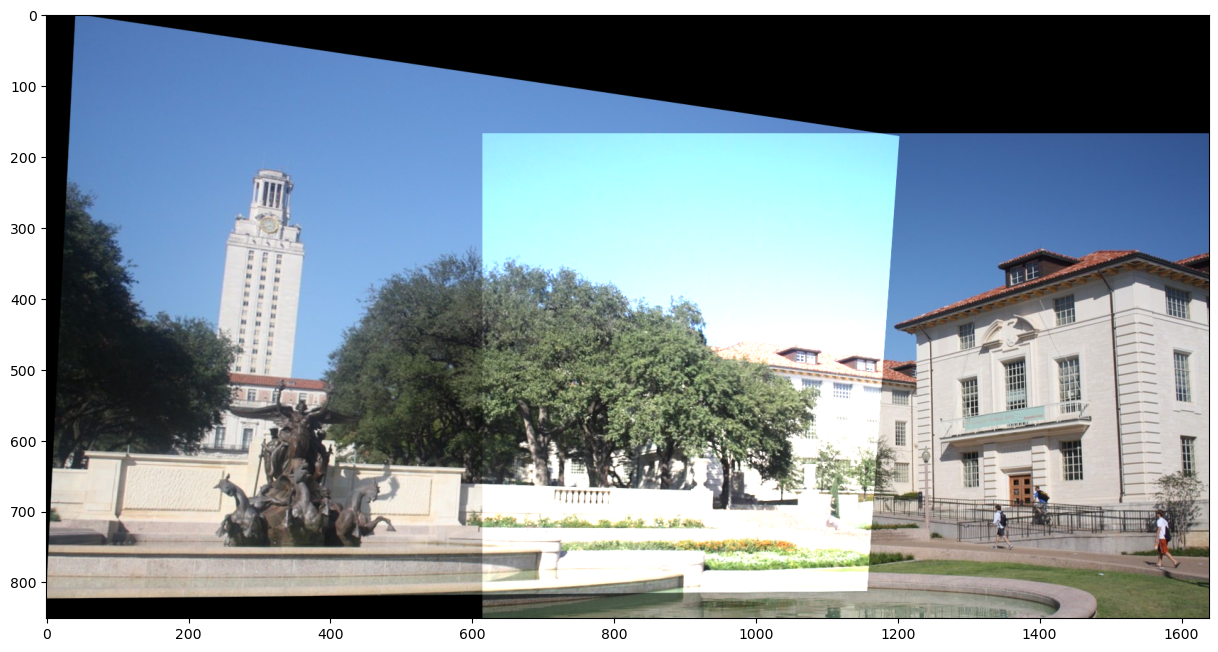

In [11]:
_,pano,_,_=warpTwoImages(rgb_l,rgb_r,H,True)
plt.figure(figsize=(15,15))
plt.imshow((pano).clip(0,255).astype('uint8'))